In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
os.environ["KERAS_BACKEND"] = "torch"
import keras

# Under construction
<font color="red"><b>Author: Wim R.M. Cardoen (wcardoen@gmail.com)</b></font><br>
If you stumble by chance on this website and find errors, have comments/suggestions, please send 
an email to the author! Thanks.<br>

# Hands-on Introduction to Deep Learning (Lecture 2)

## Synopsis  
In <a href="./lecture1.ipynb"><b>Lecture 1</b></a>, we worked out the details of <font color="green"><b>logistic regression</b></font> as
the simplest neural net.<br>
We introduced the following concepts:
* **neuron** (`perceptron`)
* **activation function** (`sigmoid`)
* **loss function** (metric to optimize the neural net) for `binary classification`
* **gradient descent method** (`optimization` of the weights and biases)
* **forward propagation** (moving forward from the input to the loss function)
* **backward propagation** (moving backwards from the loss function to the inputs to calculate the gradients)

## Goal
In this Lecture, we will generalize the previous example to a <font color="green"><b>fully connected dense neural net</b></font>.

## Caveat
You will find some paragraphs with the heading <font color="red"><b>Note (for sake of completeness)</b></font><br>
These can be skipped and are for people who want to dig deeper in the subject.

# 1.Dense Neural Nets

## Definitions:
A **fully connected dense neural network** of <font color="green"><b>depth</b></font> $L$ is a neural net where:
- <font color="green"><b>every neuron</b></font> in layer ($l$) is connected to <font color="green"><b>every</b></font> neuron in layer ($l+1$) where $l=\{0,1,2,\ldots,L-1\}$.
- these connections are **directed** and **acyclic** (<a href="https://en.wikipedia.org/wiki/Directed_acyclic_graph"><b>DAG</b></a>), i.e. they are unidirectional from layer $l$ towards layer $l+1$ and do
  **NOT** cycle back.
- the number of nodes in layer $l$ (<font color="green"><b>width</b></font> of layer $l$) will be designated as $n^{[l]}$.
- types of layers:
  + <font color="green"><b>input</b></font> layer: $l=0$. It is **NOT** counted as a real layer (this will become obvious soon!). 
  + <font color="green"><b>output</b></font> layer: $l=L$.
  + <font color="green"><b>hidden</b></font> layers: $l \in \{1,2,\ldots,L-1\}$.

Neural nets with <font color="green"><b>NO hidden</b></font> layers ($L=1$) are called 
<font color="green"><b>shallow</b></font>.<br> The neural net we discussed previously (Lecture 1) is an example of a shallow neural net with $n^{[0]}=2$ and $n^{[1]}=1$.


## Example:
The image below displays a deep neural with $L=4$ layers (neural net of depth 4).

<img src="dnn_4layers.jpeg" alt="Deep neural net with 4 layers" style="width:65%; height:auto">

* <font color="green"><b>input</b></font> layer: layer $0$
  + the input layer requires input vectors/examples each of length $n^{[0]}=6$
* <font color="mediumslateblue"><b>hidden</b></font> layers: layers $1,2,3$
  + layer $1$: has $4$ nodes ($n^{[1]}=4$)
  + layer $2$: has $3$ nodes ($n^{[2]}=3$)
  + layer $3$: has $6$ nodes ($n^{[3]}=6$)
* <font color="red"><b>output</b></font> layer: layer $4$
  + layer $4$: has $4$ nodes ($n^{[4]}=4$)

The output layer is followed by a <font color="green"><b>loss function</b></font> which is 
the <font color="green"><b>objective function</b></font> to be minimized during the <font color="green"><b>training</b></font> phase.

<font color="red"><b>Note (for sake of completeness)</b></font><br>
There are exceptions to the aforementioned definition, e.g. to name a few:
+ <a href="https://en.wikipedia.org/wiki/Residual_neural_network"><b>Residual Neural Networks</b></a> (ResNets)
+ <a href="https://en.wikipedia.org/wiki/Bidirectional_recurrent_neural_networks"><b>Bidirectional Recurrent Neural Networks</b></a> (BRNNs)
+ $\ldots$
 
This type of networks will **NOT** be covered in this lecture but may the subject of future talks.

# 2.Activation functions
Previously, we discussed the `sigmoid` activation function:<br>
  $\begin{eqnarray}
     \sigma(z) & = & \frac{1}{1\,+\,\exp(-z)}\,, z \,\in \mathbb{R}
  \end{eqnarray}$

The activation functions for the output layer and the hidden layers
are in general <font color="green"><b>different</b></font>.

- <font color="red"><b>output</b></font> layer:<br>the activation function is <font color="green"><b>determined</b></font> by the subsequent loss function.
  * `binary` classification: <br>
    + `sigmoid` $\sigma(z)$
    + $\sigma(z) \in [0,1]$
  * `multiclass` classification: 
    + $\begin{eqnarray}
       \texttt{softmax}(z_{ij}) & := &  \frac{\exp(z_{ij})}{ \displaystyle\sum_{k=1}^C \exp(z_{ik})}
        \end{eqnarray}$
    + $C$ stands for the number of classes 
    + $\texttt{softmax}(z_{ij}) \in [0,1]$  
  * `linear regression`:<br>
    + `1` (no action) 

- <font color="mediumslateblue"><b>hidden</b></font> layers:<br>
  There are several activation functions that are commonly used:
  * $\texttt{relu}(x)$: (**Re**ctified **L**inear **U**nit)<br>
    + $\texttt{relu}(x) := \max(0,x)$
    + $\texttt{relu}(x) \geq 0 $
  * $\texttt{lrelu}(x;\alpha)$: (**L**eaky **Re**ctified **L**inear **U**nit)<br>
    + $\texttt{lrelu}(x;\alpha) := \max(\alpha x, x) \,,\,0 \leq \alpha < 1$
  * $\texttt{gelu}(x)$: (**G**aussian-**e**rror **Linear** **U**nit)<br>
    + $\begin{eqnarray} \texttt{gelu}(x) &:= & x\,\Phi(x) \end{eqnarray}$ <br>
      where $\Phi(x)$ stands for the <a href="https://en.wikipedia.org/wiki/Cumulative_distribution_function"><b>CDF</b></a> of the standard normal distribution.
    + $\begin{eqnarray} \texttt{gelu}(x)              & = &x \displaystyle\int_{-\infty}^x \frac{1}{\sqrt{2 \pi}}{ \exp\bigg(-\frac{t^2}{2}\bigg)} dt
       \end{eqnarray}$
  * $\texttt{swish}(x;\beta) := x \, \sigma(\beta x)$    
  * $\texttt{tanh}(x)$: (Hyperbolic Tangent)<br>
    + $\texttt{tanh}(x) := \displaystyle \frac{\exp(x) - \exp(-x)}{\exp(x) + \exp(-x)}$
    + $\texttt{tanh}(x) \in [-1,1]$
  * $\ldots$  <br>
  
  <font color="red"><b>Note</b></font>:<br>
  `ReLU` is the most commonly used activation function within the <font color="mediumslateblue"><b>hidden</b></font> layers.


## Plot of some of the activation functions
Below you will find some of the aforementioned activation functions displayed.

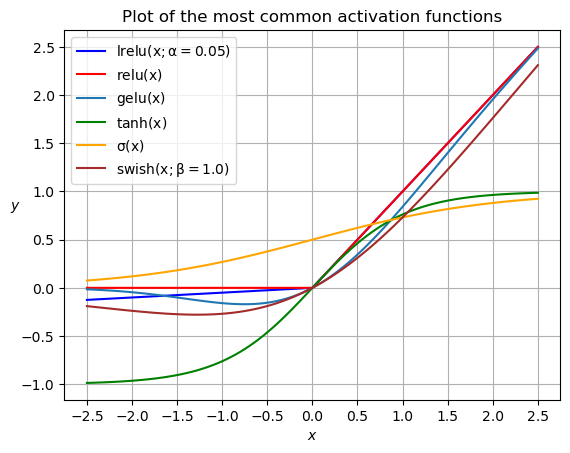

In [49]:
START= -2.5
END= 2.5
DENS_PER_UNIT=20
ALPHA=0.05
x = np.linspace(start=START,stop=END, num=int((END-START))*DENS_PER_UNIT+1)
y_relu = np.maximum(0,x)
y_lrelu = np.maximum(ALPHA*x,x)
y_tanh = np.tanh(x)
y_sigmoid = 1.0/(1.0+np.exp(-x))
y_swish = x*y_sigmoid
y_gelu = x* ss.norm.cdf(x)
plt.title(r"Plot of the most common activation functions")
plt.plot(x,y_lrelu, label=r"$\mathrm{lrelu(x;\alpha=0.05)}$", color="blue")
plt.plot(x,y_relu, label=r"$\mathrm{relu(x)}$", color="red")
plt.plot(x,y_gelu, label=r"$\mathrm{gelu(x)}$")
plt.plot(x,y_tanh, label=r"$\mathrm{tanh(x)}$", color="green")
plt.plot(x,y_sigmoid, label=r"$\mathrm{\sigma(x)}$", color="orange")
plt.plot(x,y_swish, label=r"$\mathrm{swish(x;\beta=1.0)}$", color="brown")
plt.xticks(np.arange(START,END+0.5, step=0.5))
plt.xlabel(r"$x$")
plt.ylabel(r"$y$",rotation=0)
plt.grid()
plt.legend()
plt.show()

# 3.Cost/Loss functions

* The <font color="green"><b>cost</b></font> function ($\mathcal{C}$) is defined as follows:<br>
$\begin{eqnarray}
    \mathcal{C} & := & \frac{1}{m} \sum_{i=1}^m \mathcal{L}^{(i)}
 \end{eqnarray}$<br>
 where $\mathcal{L}^{(i)}$ stands for the <font color="green"><b>loss</b></font> function for example $i$ and $m$ stands for the batch
 of examples used.

* Depending on the task we want to accomplish, we need to use different loss functions.<br>
  The most <font color="blue"><b>common</b></font> loss functions are:<br>
  * `binary classification`<br>
    $\begin{eqnarray}
        \mathcal{L}^{(i)} &:= & -y_i\,\log(a^{[L]}_i)
      \end{eqnarray}$<br>
    where:
    - $y_i$ is either $0$ or (<font color="red"><b>exclusive</b></font>) $1$ and represents the label of example $i$.
  * `multiclass classification`<br>
    $\begin{eqnarray}
        \mathcal{L}^{(i)} &:= & \sum_{j=1}^C -y_{ij}\,\log(a^{[L]}_{ij})
      \end{eqnarray}$<br>
    where:<br>
    + $y_i$ is a <a href="https://en.wikipedia.org/wiki/One-hot"><b>one-hot</b></a> encoding vector representing the <font color="green"><b>label</b></font> of example $i$.
    + $C$ stands for the <font color="green"><b>number of classes</b></font>.
  * `linear regression`<br>
    $\begin{eqnarray}
        \mathcal{L}^{(i)} &:= \frac{1}{2} (y_i - a^{[L]}_i)^2
      \end{eqnarray}$<br>
    where:<br>
    + $y_i$ is the value associated with example $i$.
* The cost function can also contain extra terms (i.e. <font color="green"><b>regularization</b></font>) to constrain certain parameters/prevent <font color="green"><b>overfitting</b></font>.<br>
  We will elaborate on this later on in this Lecture.


<font color="red"><b>Note (for sake of completeness)</b></font><br>
- A lot of loss functions can be easily derived using:
  + the <a href="https://en.wikipedia.org/wiki/Maximum_likelihood_estimation"><b>Maximum Likelihood Estimation</b></a> (MLE) method or using the <a href="https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence"><b>Kullback-Leibler divergence</b></a>
  + combined with the theory of <a href="https://en.wikipedia.org/wiki/Generalized_linear_model"><b>Generalized Linear Models</b></a> (GLM).<br>
  e.g. `Poisson loss function` (to predict discrete counts),...
- To improve <font color="green"><b>numerical stabilty</b></font>, the activation function for the
    last layer ($L$) and the loss function are:
  + often <font color="green"><b>calculated together/at once</b></font>
  + and then bear a separate (information-theoretic) name.

- In the output layer there can be several types of activation functions at the same time,<br>
  e.g. a `linear regression` problem where we are interested at the same time:
  + in a predicted value of $a^{[L]}_{i1} \in \mathbb{R}$
  + the prediction of the variance ($ a^{[L]}_{i2}\in \mathbb{R}^+$)


# 4.Structure of the DNN: summary
- We just described the <font color="green"><b>basic structure</b></font> of a deep neural network, i.e.:
  + the layers $l \in \{0,1,\ldots, L\}$.
  + the number of nodes per layer i.e. $n^{[l]}$ for $l \in \{0,1,\ldots, L\}$.
- We also introduced the two other structural components:
  + activation functions.<br>
    <font color="green"><b>ONE</B></font> activation function ($\widehat{h}^{[l]}$) is <font color="green"><b>REQUIRED</b></font> per layer $l \in \{1,\ldots, L\}$.
  + the loss/cost function $\mathcal{L}^{(i)}/\mathcal{C}$.<br>
    The loss/cost function is only <font color="green"><b>MANDATORY</b></font> during training.

## Implementation of the previous DNN example in Keras/PyTorch

We have a deep neural with $L=4$ layers (neural net of depth 4).
* <font color="green"><b>input</b></font> layer: layer $0$
  + the input layer requires input vectors/examples each of length $n^{[0]}=6$
* <font color="mediumslateblue"><b>hidden</b></font> layers: layers $1,2,3$
  + layer $1$: has $4$ nodes ($n^{[1]}=4$) - activation $h^{[1]}$: `ReLu` 
  + layer $2$: has $3$ nodes ($n^{[2]}=3$) - activation $h^{[2]}$: `ReLu`
  + layer $3$: has $6$ nodes ($n^{[3]}=6$) - activation $h^{[3]}$: `ReLu` 
* <font color="red"><b>output</b></font> layer: layer $4$
  + layer $4$: has $4$ nodes ($n^{[4]}=4$) - activation $h^{[4]}$: `softmax`
    (We assume that the model will train to classify $4$ classes). 

In [44]:
## Keras/PyTorch code
model = keras.Sequential([
          keras.layers.Input(shape=(6,)),                      # Input: 6-dimensional input vector
          keras.layers.Dense(units=4, activation='relu'),      # Layer 1
          keras.layers.Dense(units=3, activation='relu'),      # Layer 2
          keras.layers.Dense(units=6, activation='relu'),      # Layer 3
          keras.layers.Dense(units=4, activation='softmax')])  # Output layer: 4 classes
print(model.summary())  

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 4)              │            28 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │            15 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 6)              │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 95 (380.00 B)

 Trainable params: 95 (380.00 B)

 Non-trainable params: 0 (0.00 B)

None


## <font color="blue"><b>Here comes an exercise</b></font>
Add also the low level version (PyTorch without Keras)

# 5. Training of a Deep Neural Network
- During <font color="green"><b>TRAINING</b></font>, a `function` needs to be found<br>
  which is able to <font color="green"><b>GENERALIZE</b></font> well (i.e. to deal sufficiently well with unseen examples).
- Therefore, two questions arise:
  + a. does such a `function` even exist?
  + b. and if so, how to find such a `function`/how to train a network.<br>
These questions will be addressed in short in this section and explained in detail down the road.


## The universal approximation theorems (UATs)
Describe the universal approximation theorem and provide some references.

## Training a deep neural network.

- In <a href="./lecture1.ipynb"><b>Lecture 1</b></a>, we trained a shallow neural network ($1$ node in $1$ layer).<br>
  To do so, we had to <font color="green"><b>iterate</b></font> repeatedly over the <font color="blue"><b>following loop</b></font>:
  + Perform the <font color="green"><b>forward propagation</b></font></color>.<br>Start at the input layer and proceed forward to the output layer and the loss function.
  + Perform the <font color="green"><b>backward propagation</b></font></color>.<br>Start at the loss function and recede all the way to the first layer
    in order to obtain the <font color="green"><b>gradients of the parameters</b></font>.
  + <font color="green"><b>Update the parameters</b></font> (weights and bias) using the <font color="green"><b>gradient descent</b></font> method.<br>  

  The same procedure is used to train deep neural net of $L$ layers, but a few caveats<br>

  - **Convexity of the objective function**<br>
    + In <a href="./lecture1.ipynb"><b>Lecture 1</b></a>, our objective function was <font color="green"><b>convex</b></font>.
      Therefore, when we reached the <br>
      <font color="green"><b>local minimum</b></font> we were assured to obtain the <font color="green"><b>global minimum</b></font> of the         objective function.<br>
  
    + However, the cost function for deep neural nets is in general <font color="red"><b>NOT convex</b></font>:<br>we can never be certain          that we have reached the global minimum of this highly dimensional surface.

  - **Rate of convergency**
    + The <font color="green"><b>rate of convergence</b></font> of gradient descent (first-order method) is very slow.
    + There are second-order methods to locate the minimum:
      - they <font color="green"><b>speed up</b></font> the optimization process.
      - but are very <font color="red"><b>expensive</b></font> (require the
      calculation of the Hessian for the parameters).
    + We will introduce more performant adaptations of gradient descent to enhance the convergence rate.<br><br> 

- In the next sections we will discuss:
  + the forward propagation
  + the backward propagation
  + the optimization method<br>
  
  for a deep neural net.

# 6.Forward propagation (dense deep neural net)

We extracted a slice from the previous example to illuminate the principle of forward propagation .<br><br>
<img src="forward1.jpeg" alt="Connections between layers 1 and 2" style="width:65%; height:auto"><br>

**Setup/Context**
- We have a dense deep neural net with **$L$** layers. Each layer $l$ has **$n^{[l]}$** nodes.
- The input layer ($l=0$) has $n^{[0]}$ nodes.<br>
- The number of nodes ($n^{[0]}$) is **equal** to the dimensionality of each input vector $x_i$, where:<br>
  $\begin{eqnarray}
    x_i := \begin{pmatrix}
            x_{i,1} & x_{i,2} & \ldots & x_{i,n^{[0]}}
           \end{pmatrix}
  \end{eqnarray}$<br>
- $ a^{[0]}_{i} := x_i $   

**Transformation**
- At <font color="green"><b>layer</b></font> $l \in \{1,2,\ldots,L\}$ the vector associated with example $i$ is transformed as follows:<br>
    $\begin{eqnarray}
      z^{[l]}_{i,k} &= & \sum_{j=1}^{n^{[l-1]}} a^{[l-1]}_{i,j} w^{[l]}_{j,k} + b^{[l]}_k \; \;,\; k \in \{1,2, \dots,n^{[l]}\} \\
      a^{[l]}_{i,k} &= & \widehat{h}^{[l]}(z^{[l]}_{i,k}) \; \;,\; k \in \{1,2, \dots,n^{[l]}\}
    \end{eqnarray}$<br>
  i.e.:
    + at **each** node $k$ of layer $l$ the input vector $a^{[l-1]}_i$ is <font color="green"><b>weighted</b></font> and a <font color="green"><b>bias</b></font> is added ($ \Rightarrow z^{[l]}_{i,k}$)
    + subsequently, at **each** node $k$ of layer $l$ the corresponding value $z^{[l]}_{i,k}$ is <font color="green"><b>transformed</b></font> using a **non-linear** activation function
      $\widehat{h}^{[l]}$.<br> The output of the activation function for example $i$ at node $k$ of layer $l$ is labeled $a^{[l]}_{i,k}$.<br>
    + given that the $l$-th layer contains $n^{[l]}$
      nodes, the transformation of example $i$ at layer $l$ results into a vector of dimension $n^{[l]}$.

**Vectorization**   
- This procedure can easily be <font color="green"><b>vectorized</b></font>:<br> $m$ example vectors can be transformed simultaneously/in batch at the same layer .

- <font color="green"><b>Algorithm</b></font>:
  + Let $X$ be an input matrix of $m$ examples (one example per row) and $n^{[0]}$ columns.
  + $A^{[0]}:=X$ $,\hspace{0.5in}A{[0]} \in \mathbb{R}^{m\times n^{[0]}}$<br>
    $\texttt{for(l=1,..,L)}$<br>
    $\texttt{do}$<br>
    $\begin{eqnarray}
      \hspace{0.35in}Z^{[l]} &= & A^{[l-1]}W^{[l]} + b^{[l]} \\
      A^{[l]} &= &\widehat{h}^{[l]}(Z^{[l]})
     \end{eqnarray}$<br>
    $\texttt{done}$
  + Calculate $\mathcal{C}$ using $A^{[L]}$ and $Y$.

**Summary**   
- In order to learn, the network requires weight, biases matrices and activation functions for each layer $l$:  
  * <font color="green"><b>Weight matrices</b></font>: $W^{[l]} \in \mathbb{R}^{n^{[l-1]}\times n^{[l]}}$
  * <font color="green"><b>Bias vectors</b></font>: $b^{[l]} \in \mathbb{R}^{ 1 \times n^{[l]}}$
  * <font color="green"><b>Non-linear activation functions</b></font>: $\widehat{h}^{[l]}$
- The weight matrices and the bias vectors are known as the <font color="green"><b>PARAMETERS</b></font> of the model.

# 7.Back propagation
* The calculation of the cost function (<font color="green"><b>forward propagation</b></font>):<br>
  starts at layer $1$, then goes to layer $2$ and propagates all the way to the output layer $L$.<br>
  The output of the last layer $L$ is used to calculate the cost function $\mathcal{C}$.

* The <font color="green"><b>back propagation</b></font> operates in the <font color="green"><b>exactly opposite</b></font> direction:
  - it starts with the cost function $\mathcal{C}$ and recedes all the way back to $l=1$.
  - during the back propagation, the <font color="green"><b>gradients</b></font> of the parameters $W^{[l]}, b^{[l]}$ are calculated.


<font color="red"><b>Note (for sake of completeness)</b></font><br>
In these section we will describe the backpropagation in more detail.<br>The expressions below can easily
be derived by the application of the chain rule.

- We start at the <font color="green"><b>output</b></font> layer ($l=L$):
  * $\begin{eqnarray}
     \mathcal{C} & := & \frac{1}{m} \sum_{i=1}^m \mathcal{L}^{(i)}
     \end{eqnarray}$
  * Let:<br>
    $\begin{eqnarray}
     (dA^{[L]})_{ij} &:=& \frac{\partial \mathcal{L}^{(i)}} {\partial a^{[L]}_{i,j}} \\
     (dZ^{[L]})_{ij} &:=& \frac{\partial \mathcal{L}^{(i)}} {\partial z^{[L]}_{i,j}} &= &\sum_{k=1}^{n^{[L]}}\frac{\partial \mathcal{L}^{(i)}} {\partial a^{[L]}_{i,k}} \frac{\partial a^{[L]}_{i,k}}
     {\partial z^{[L]}_{i,j}}\\
     (dW^{[L]})_{i,j} & := &  \frac{\partial \mathcal{C}}{\partial w^{[L]}_{i, j}} \\
     (db^{[L]})_{j} & := &  \frac{\partial \mathcal{C}}{\partial b^{[L]}_{j}} 
    \end{eqnarray}$
  * The application of the <font color="green"><b>chain rule</b></font> results into:<br>
    $\begin{eqnarray}
     dW^{[L]} & = & \frac{1}{m}(A^{[L-1]})^T.dZ^{[L]} \\
     db^{[L]} & = & \frac{1}{m}\sum_{i=1}^m(dZ^{[L]})_i 
    \end{eqnarray}$
  
- Using the relation $Z^{[l]} = A^{[l-1]}.W^{[l]} + b^{[l]}$<br>
  we can determine $dW^{[l]}, db^{[l]}$ for the <font color="green"><b>other layers</b></font> $ l \in \{L-1,\ldots,2,1\}$.

  Therefore,<br>
  $\texttt{for(l=L,...,2)}$<br>
  $\texttt{do}$<br>
  $\begin{eqnarray}
      \hspace{0.35in}dA^{[l-1]} &= & dZ^{[l]}.(W^{[l]})^T \\
                     dZ^{[l-1]} &= & dA^{[l-1]} \odot d\widehat{H}^{[l-1]} \\
                     dW^{[l-1]} & =& \frac{1}{m}(A^{[l-2]})^T.dZ^{[l-1]} \\
                     db^{[l-1]} & =& \frac{1}{m}\sum_{i=1}^m(dZ^{[l-1]})_i
  \end{eqnarray}$<br>
  $\texttt{done}$

  where:
  + $\odot$ stands for the <a href="https://en.wikipedia.org/wiki/Hadamard_product_(matrices)"><b>Hadamard product</b></a>
  + $(d\widehat{H}^{[l-1]})_{i,j} := (\widehat{h}^{\prime[l-1]})_{i,j} $<br>
  
  <font color="brown"><b>Remark:</b></font>
    
  + $dZ^{[l-1]} =  dA^{[l-1]} \odot d\widehat{H}^{[l-1]}$ <br>$\texttt{iff}$<br>
    $\begin{eqnarray}
      \frac{\partial a^{[l]}_{ik}}{\partial z^{[l]}_{ij}} &= &\widehat{h}^{[l]}(z^{[l]}_{ij})
      \end{eqnarray}$ which is indeed the case for `ReLU`
  

# 8.Optimization

## Using simple gradient descent
Once we have obtained **ALL** the gradients for the parameters using back propagation,<br> 
we can <font color="green"><b>update the parameters</b></font> using gradient descent, in the following way:

$\texttt{for(l=1,...,L)}$<br>
  $\texttt{do}$<br>
  $\begin{eqnarray}
      W^{[l]} & = & W^{[l]} - \alpha \,dW^{[l]} \\
      b^{[l]} & = & b^{[l]} - \alpha \,db^{[l]} \\
  \end{eqnarray}$<br>
  $\texttt{done}$

The variable $\alpha$ is called a <font color="green"><b>hyper parameter</b></font> (all variables <font color="blue"><b>beyond</b></font> (
ὑπέρ) the parameters $W^{[l]},b^{[l]}$ where $l \in \{1,2,\ldots,L\}$).<br> The hyper parameter $\alpha$ is known as the <font color="green"><b>learning rate</b></font> in AI parlance. 

### Setting the learning rate $\alpha$
If we choose:
+ a <font color="red"><b>too big</b></font> value of $\alpha$, we can make steps that are too large and miss the path to the minimum.
+ a <font color="red"><b>very small value</b></font> of $\alpha$, we will get an extremely slow rate of convergence.

There are algorithms that <font color="green"><b>modify the learning rate</b></font> during the minimization process. We will elaborate 
on this later on.

### Epochs and the batch size $m$

- In our previous derivations we always used a batch of $m$ examples without specifying the size of $m$.
- In <font color="green"><b>regular/batch gradient descent</b></font> we consider **all examples at once**:
  + to calculate the gradient
  + and update the parameters.<br>
  In the case of ML, this approach in <font color="red"><b>generally impossile</b></font> to
  the sheer size of the data.

- <font color="green"><b>In praxi</b></font>, the following approach is followed in ML:
  + the complete dataset ($N$ examples) is split up into `mini-batches` of size $m$. 
  + it takes $\kappa:= \frac{N}{m}$ `mini-batches` to proceed through the dataset (assuming $m | N$).
  + after each `mini-batch`, the gradients will be calculated and the parameters updated.
  + A <font color="green"><b>single pass</b></font> through the entire data set is called an <font color="green"><b>epoch</b></font>.
  + When $m=1$, the gradient procedure is known as <font color="green"><b>stochastic gradient descent</b></font>.<br>
    (This is <font color="red"><b>NOT a great approach</b></font> - <font color="red"><b>volatility</b></font> of the loss)
  + $m$ is a hyper parameter. It is often set to be a power of $2$ (data alignment with the memory architecture).

So, we end up with the following <font color="green"><b>training algorithm</b></font>:

$\texttt{for(i=1,...,nepochs)}$<br>
$\texttt{do}$<br>
$\hspace{0.35in}\texttt{for(ibatch=1,...,nbatches)}$<br>
$\hspace{0.35in}\texttt{do}$<br>
$\hspace{0.7in}\texttt{Calculate Cost (forward)}$<br>
$\hspace{0.7in}\texttt{Calculate gradients (backward)}$<br>
$\hspace{0.7in}\texttt{Update parameters}$<br>
$\hspace{0.35in}\texttt{done}$<br>
$\texttt{done}$<br>
 
### Scaling of the input - standardizing
In order to improve the optimization : scale the input

<font color="red"><b>Still to be discussed</b></font>
- Initialization of the parameters W and b (Glorot and He).
- Scaling of the input (e.g. standardizing) -  Why is this useful?
  

# 9.Training/validation/testing
<font color="red"><b>Still to be worked out </b></font>
- Folding
- Bias and Variance
- Overfitting & underfitting
- How to find what is the issue and to improve.
- How to test hyper parameters 

# 10.Improvements




<font color="red"><b>Still to be worked out</b></font>
- Regularization:
  * Lasso, Ridge, Elastic
  * Dropout
- BatchNorm
- Improving the optimization process
  * Momentum methods (Ada, RmsProp)
  * Adam,..
  * Second-order methods
  * $\alpha$: as a function
- Debugging     